In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms 
import os 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

print(torch.__version__)

1.11.0


In [3]:
# configuration to detect cuda or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
DATA_PATH = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [5]:
import urllib
import os 
import shutil
from zipfile import ZipFile

urllib.request.urlretrieve(DATA_PATH, "hymenoptera_data.zip")

with ZipFile("hymenoptera_data.zip", "r") as zipObj:
    zipObj.extractall() 

os.rename("hymenoptera_data", "data")

TypeError: 'str' object is not callable

In [7]:
# configure root folder on your 
data_dir = "./data"

# custom transform to flattern the image tensors
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size 

    def __call__(self, img):
        return torch.reshape(img, self.new_size)


# transformation used to standardize and normalize the datasets 
data_transforms = {
    'train': transforms.Compose([transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ReshapeTransform((-1,))]), # flattens the data 
    'val': transforms.Compose([transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ReshapeTransform((-1,))])
}

# load the corresponding folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
            for x in ['train', 'val']}

In [8]:
train_dataset = torch.utils.data.DataLoader(image_datasets['train'], batch_size=len(image_datasets['train']), shuffle=True)
test_dataset = torch.utils.data.DataLoader(image_datasets['val'], batch_size=len(image_datasets['val']), shuffle=True)

Dimension of image: torch.Size([244, 150528]) 
 Dimension of labels: torch.Size([244])


/var/folders/gt/7hl_3dpd1tx5hxgq33gg36ph0000gn/T/ipykernel_50376/3250418696.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756028548/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  plt.imshow(x[160].reshape(1, 3, 224, 224).squeeze().T.numpy())


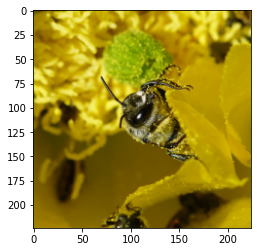

In [10]:
# load the entire dataset
x, y = next(iter(train_dataset))

# print one example 
dim = x.shape[1]
print(f"Dimension of image: {x.shape} \n Dimension of labels: {y.shape}")

plt.imshow(x[160].reshape(1, 3, 224, 224).squeeze().T.numpy())

In [11]:
OUTPUT_DIM = 1
class LR(torch.nn.Module):
    def __init__(self, dim, lr=torch.scalar_tensor(0.01)):
        super(LR, self).__init__()

        #initialize parameters 
        self.w = torch.zeros(dim, OUTPUT_DIM)
        self.b = torch.scalar_tensor(0).to(device)
        self.grads = {
            "dw": torch.zeros(dim, OUTPUT_DIM, dtype=torch.float).to(device),
            "db": torch.scalar_tensor(0).to(device)
        }
        self.lr = lr.to(device)

    def forward(self, x):
        # compute forward 
        z = torch.mm(self.w.T, x) + self.b 
        a = self.sigmoid(z)
        return a
    
    def sigmoid(self, z):
        return 1 / (1 + torch.exp(-z))

    def backward(self, x, yhat, y):
        # compute backward
        self.grads["dw"] = (1/x.shape[1]) * torch.mm(x, (yhat - y).T)
        self.grads["db"] = (1/x.shape[1]) * torch.sum(yhat- y) 

    def optimize(self):
        # optimization step 
        self.w = self.w - self.lr*self.grads["dw"]
        self.b = self.b - self.lr* self.grads["db"]

# utility functions 
def loss(yhat, y):
    m = y.size()[1]
    return -(1/m) * torch.sum(y* torch.log(yhat) + (1-y)*torch.log(1-yhat))

def predict(yhat, y):
    y_prediction = torch.zeros(1, y.size()[1])

    for i in range(yhat.size()[1]):
        if yhat[0, i] < 0.5:
            y_prediction[0, i] = 0
        else: 
            y_prediction[0, i] = 1

    return 100 - torch.mean(torch.abs(y_prediction - y)) * 100

In [14]:
# model pretesting 
x, y = next(iter(train_dataset))

x_flatten = x.T 
y = y.unsqueeze(0) 

# num_px is the dimestion of the image 
dim = x_flatten.shape[0]

# model instance 
model = LR(dim)
model.to(device)
yhat = model.forward(x_flatten.to(device))
yhat = yhat.data.cpu()

cost = loss(yhat, y)
prediction = predict(yhat, y)
print("Cost: ", cost)
print("Accuracy: ", prediction)

# backpropagate
model.backward(x_flatten.to(device), yhat.to(device), y.to(device))
model.optimize()

Cost:  tensor(0.6931)
Accuracy:  tensor(49.5902)


In [20]:
costs = []
dim = x_flatten.shape[0]
learning_rate = torch.scalar_tensor(0.0001).to(device)
num_iteration = 120 
lrmodel = LR(dim, learning_rate)
lrmodel.to(device)

# transform the data
def transform_data(x, y):
    x_flatten = x.T 
    y = y.unsqueeze(0) 
    return x_flatten, y 

# train the model 
for i in range(num_iteration):
    x ,y = next(iter(train_dataset))
    test_x, test_y = next(iter(test_dataset))

    x, y = transform_data(x, y)
    test_x, test_y = transform_data(test_x, test_y)

    # forward 
    yhat = lrmodel.forward(x.to(device))
    cost = loss(yhat.data.cpu(), y)
    train_pred = predict(yhat, y)

    # backpropagate
    lrmodel.backward(x.to(device), yhat.to(device), y.to(device))
    lrmodel.optimize()

    # test
    yhat_test = lrmodel.forward(test_x.to(device))
    test_pred = predict(yhat_test, test_y)

    if i % 10 == 0:
        costs.append(cost)
        print(f"Cost after iteration {i}: {cost} | Train Acc: {train_pred} | Test Acc: {test_pred}")

Cost after iteration 0: 0.6931470632553101 | Train Acc: 49.59016418457031 | Test Acc: 45.75163269042969
Cost after iteration 10: 0.6691471338272095 | Train Acc: 64.3442611694336 | Test Acc: 54.24836730957031
Cost after iteration 20: 0.6513182520866394 | Train Acc: 68.44261932373047 | Test Acc: 54.24836730957031
Cost after iteration 30: 0.6367825865745544 | Train Acc: 68.03278350830078 | Test Acc: 54.24836730957031
Cost after iteration 40: 0.6245337128639221 | Train Acc: 69.67213439941406 | Test Acc: 54.90196228027344
Cost after iteration 50: 0.6139225363731384 | Train Acc: 70.90164184570312 | Test Acc: 56.20914840698242
Cost after iteration 60: 0.6045236587524414 | Train Acc: 72.54098510742188 | Test Acc: 56.86274337768555
Cost after iteration 70: 0.5960511565208435 | Train Acc: 74.18032836914062 | Test Acc: 57.51633834838867
Cost after iteration 80: 0.5883085131645203 | Train Acc: 73.77049255371094 | Test Acc: 57.51633834838867
Cost after iteration 90: 0.5811557769775391 | Train Acc: 

KeyboardInterrupt: 

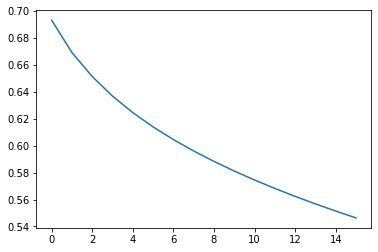

In [21]:
# the trend in the context of loss 
plt.plot(costs)
plt.show()